In [1]:
import b3d
import jax.numpy as jnp
import os
from b3d import Mesh, Pose
import jax
import genjax
from genjax import Pytree
import rerun as rr
from b3d.modeling_utils import uniform_discrete, uniform_pose, gaussian_vmf
import matplotlib.pyplot as plt
from matplotlib import cm, ticker
from functools import partial
import importlib

In [2]:
b3d.rr_init("interactive")
key = jax.random.PRNGKey(0)
ycb_dir = os.path.join(b3d.get_assets_path(), "bop/ycbv")
scene_id = 49
image_id = 109 #100

# all_data = b3d.io.get_ycbv_test_images(ycb_dir, scene_id, [image_id])
all_data = b3d.io.get_ycbv_test_images(ycb_dir, scene_id, [image_id, 594])


meshes = [
    Mesh.from_obj_file(os.path.join(ycb_dir, f'models/obj_{f"{id + 1}".rjust(6, "0")}.ply')).scale(0.001)
    for id in all_data[0]["object_types"]
]

height, width = all_data[0]["rgbd"].shape[:2]
fx,fy,cx,cy = all_data[0]["camera_intrinsics"]
scaling_factor = 0.2
renderer = b3d.renderer.renderer_original.RendererOriginal(
    width * scaling_factor, height * scaling_factor, fx * scaling_factor, fy * scaling_factor, cx * scaling_factor, cy * scaling_factor, 0.01, 2.0
)
observed_rgbd_scaled_down = b3d.resize_image(all_data[0]["rgbd"], renderer.height, renderer.width)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


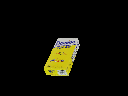

In [3]:
initial_camera_pose = all_data[0]["camera_pose"]
initial_object_poses_gt = all_data[0]["object_poses"]
IDX = 0
pose = initial_camera_pose.inv() @ initial_object_poses_gt[IDX]
rendered_rgbd_gt = renderer.render_rgbd_from_mesh(meshes[IDX].transform(pose))
b3d.viz_rgb(rendered_rgbd_gt)


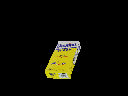

In [4]:
initial_camera_pose = all_data[0]["camera_pose"]
initial_object_poses_perturbed = all_data[1]["object_poses"]
IDX = 0
pose = initial_camera_pose.inv() @ initial_object_poses_perturbed[IDX]
rendered_rgbd_perturbed = renderer.render_rgbd_from_mesh(meshes[IDX].transform(pose))
b3d.viz_rgb(rendered_rgbd_perturbed)

In [5]:
importlib.reload(b3d.colors)
def labd_to_rgbd(labd):
    return jnp.concatenate(
        [
            b3d.colors.lab_to_rgb(labd[..., :3]),
            labd[..., 3:4]
        ],
        axis=-1
    )

def rgbd_to_labd(rgbd):
    return jnp.concatenate(
        [
            b3d.colors.rgb_to_lab(rgbd[..., :3]),
            rgbd[..., 3:4]
        ],
        axis=-1
    )

In [6]:
@Pytree.dataclass
class MaskedKImageLikelihood(genjax.ExactDensity):
    def sample(self, key, row_coordinates, column_coordinates, variances, center_points, lower_bound, upper_bound, image_height, image_width):
        observed_image = jnp.zeros((image_height.const, image_width.const, 4))

        sampled_values = jax.vmap(genjax.truncated_normal.sample, in_axes=(0, 0, 0, None, None))(
            jax.random.split(key, len(row_coordinates)), center_points, variances,
            lower_bound, upper_bound
        )
        observed_image = observed_image.at[row_coordinates, column_coordinates, :].set(sampled_values)
        return observed_image

    def logpdf(self, observed_labd, row_coordinates, column_coordinates, variances, center_points, lower_bound, upper_bound, image_height, image_width):
        subset_observed_labd = observed_labd[row_coordinates, column_coordinates]
        scores = jax.vmap(genjax.truncated_normal.logpdf, in_axes=(0, 0, 0, None, None))(
            subset_observed_labd, center_points, variances,
            lower_bound, upper_bound
        )
        return scores.sum()

masked_k_image_likelihood = MaskedKImageLikelihood()

-283522.9
-284677.06


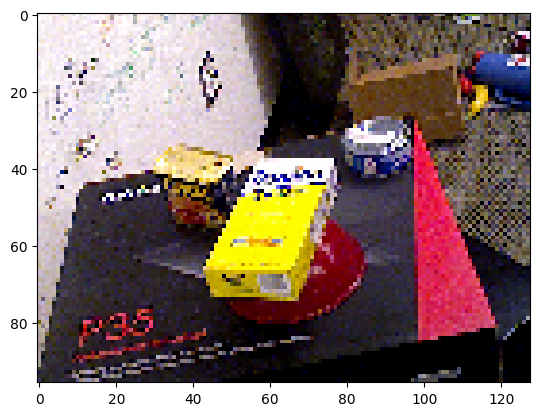

In [7]:
@genjax.gen
def ray_model(rendered_rgbd, likelihood_args):
    k = likelihood_args["k"].const
    image_height, image_width = likelihood_args["image_height"], likelihood_args["image_width"]

    row_coordinates = genjax.categorical.vmap(in_axes=(0,))(
            jnp.ones((k, image_height.const))
    )  @ "row_coordinates"
    column_coordinates = genjax.categorical.vmap(in_axes=(0,))(
            jnp.ones((k, image_width.const))
    ) @ "column_coordinates"

    rgb = rendered_rgbd[row_coordinates, column_coordinates, :3]
    lab = b3d.colors.rgb_to_lab(rgb)
    depth = rendered_rgbd[row_coordinates, column_coordinates, 3]

    outlier_probability = genjax.uniform(0.0, 1.0) @ "outlier_probability"
    inlier_color_variance = genjax.uniform(0.0001, 100.0) @ "inlier_color_variance"
    inlier_lightness_variance = genjax.uniform(0.0001, 100.0) @ "inlier_lightness_variance"
    inlier_depth_variance = genjax.uniform(0.0001, 10.0) @ "inlier_depth_variance"


    is_outlier = genjax.bernoulli.vmap(in_axes=(0,))(
        jnp.ones(k) * jax.scipy.special.logit(outlier_probability)
    )@ "is_outlier"

    no_mesh_surface = (depth == 0.0)

    is_outlier_adjusted = jnp.logical_or(is_outlier, no_mesh_surface)


    adjusted_lab_variance = (
        is_outlier_adjusted[..., None] * 1000000.0 +
        (1.0 - is_outlier_adjusted)[...,None] * jnp.ones((k,3)) * jnp.array([inlier_lightness_variance, inlier_color_variance, inlier_color_variance])
    )
    adjusted_depth_variance = is_outlier_adjusted * 1000000.0 + jnp.ones(k) * inlier_depth_variance
    variances = jnp.concatenate([adjusted_lab_variance, adjusted_depth_variance[:,None]], axis=-1)

    noiseless_labd = jnp.concatenate([lab, depth[:,None]], axis=-1)

    sampled_labd = masked_k_image_likelihood.sample(
        key,
        row_coordinates,
        column_coordinates,
        variances,
        noiseless_labd, jnp.array([0.0, -128.0, -128.0, 0.0]), jnp.array([100.0, 128.0, 128.0, 20.0]), image_height, image_width
    )

    observed_labd = masked_k_image_likelihood(
        row_coordinates,
        column_coordinates,
        variances,
        noiseless_labd, jnp.array([0.0, -128.0, -128.0, 0.0]), jnp.array([100.0, 128.0, 128.0, 20.0]), image_height, image_width
    ) @ "observed_labd"

    observed_rgbd = labd_to_rgbd(observed_labd)
    sampled_rgbd = labd_to_rgbd(sampled_labd)
    return {"sampled_rgbd": sampled_rgbd, "observed_rgbd": observed_rgbd}

    
@partial(jax.jit, static_argnums=(2,3,4))
def trace_from_parameters(
    key,
    rendered_rgbd,
    k,
    image_height,
    image_width,
    outlier_probability,
    inlier_lightness_variance,
    inlier_color_variance,
    inlier_depth_variance,
    observed_rgbd,
):
    key = jax.random.split(key, 2)[-1]
    
    likelikood_args = {
        "fx": fx,
        "fy": fy,
        "k": Pytree.const(k),
        "image_height": Pytree.const(image_height),
        "image_width": Pytree.const(image_width),
    }

    choicemap = genjax.ChoiceMap.d(
        {
            "outlier_probability": outlier_probability,
            "inlier_lightness_variance": inlier_lightness_variance,
            "inlier_color_variance": inlier_color_variance,
            "inlier_depth_variance": inlier_depth_variance,
            "observed_labd": rgbd_to_labd(observed_rgbd),
        }
    )

    trace = ray_model.importance(
        key, 
        choicemap,
        (rendered_rgbd, likelikood_args,),
    )[0]
    return trace, key
    
trace_gt, key = trace_from_parameters(
    jax.random.PRNGKey(10),
    rendered_rgbd_gt,
    10000,
    rendered_rgbd_gt.shape[0], rendered_rgbd_gt.shape[1],
    inlier_lightness_variance=10.0,
    inlier_color_variance=40.0,
    inlier_depth_variance=0.1,
    outlier_probability=0.1,
    observed_rgbd=observed_rgbd_scaled_down
)

trace_perturbed, key = trace_from_parameters(
    jax.random.PRNGKey(10),
    rendered_rgbd_perturbed,
    10000,
    rendered_rgbd_perturbed.shape[0], rendered_rgbd_perturbed.shape[1],
    inlier_lightness_variance=10.0,
    inlier_color_variance=40.0,
    inlier_depth_variance=0.1,
    outlier_probability=0.1,
    observed_rgbd=observed_rgbd_scaled_down
)

choicemap = genjax.ChoiceMap.d(
    {
        "outlier_probability": 1.0,
        "inlier_lightness_variance": 1.0,
        "inlier_color_variance": 1.0,
        "inlier_depth_variance": 1.0,
    }
)
trace_gt.update(
    key, 
    choicemap,
)
print(trace_gt.get_score())

plt.imshow(trace_gt.get_retval()["observed_rgbd"][..., :3])

trace_perturbed.update(
    key, 
    choicemap,
)
print(trace_perturbed.get_score())

In [8]:
from ipywidgets import interact
import ipywidgets as widgets

import matplotlib.pyplot as plt
import numpy as np


def plot(k,
    outlier_probability,
    inlier_lightness_variance,
    inlier_color_variance,
    inlier_depth_variance,):
    global key
    trace, key = trace_from_parameters(
        key,
        rendered_rgbd_gt, k,
        rendered_rgbd_gt.shape[0], rendered_rgbd_gt.shape[1],
        outlier_probability,
        inlier_lightness_variance,
        inlier_color_variance,
        inlier_depth_variance,
        observed_rgbd_scaled_down
    )

    fig, ax = plt.subplots(1, 4, figsize=(10, 5))

    ax[0].imshow(rendered_rgbd_gt[..., :3])
    ax[0].axis('off')

    ax[1].imshow(trace.get_retval()["sampled_rgbd"][..., :3])
    ax[1].axis('off')

    ax[2].matshow(trace.get_retval()["sampled_rgbd"][..., 3])
    ax[2].axis('off')


    ax[3].imshow(trace.get_retval()["observed_rgbd"][..., :3])
    ax[3].axis('off')

# interact(plot,
#     k = widgets.IntSlider(value=10000, min=1, max=100000, step=1),
#     outlier_probability = widgets.FloatSlider(value=0.0, min=0.01, max=1.0, step=0.01),
#     inlier_color_variance = widgets.FloatSlider(value=0.1, min=0.1, max=100.0, step=0.01),
#     inlier_lightness_variance = widgets.FloatSlider(value=0.1, min=0.1, max=100.0, step=0.01),
#     inlier_depth_variance = widgets.FloatSlider(value=0.0001, min=0.0001, max=100.0, step=0.01),
# )

# Questions for vkm
# RGB is 3 channels. D is one. So doesn't RGB then get 3 times the influence as D
# The scales on L A B D are much different too.
# Outlier branch

In [9]:
def grid(
    trace,
    key,
    outlier_probability,
    inlier_lightness_variance,
    inlier_color_variance,
    inlier_depth_variance,
):
    choicemap = genjax.ChoiceMap.d(
        {
            "outlier_probability": outlier_probability,
            "inlier_lightness_variance": inlier_lightness_variance,
            "inlier_color_variance": inlier_color_variance,
            "inlier_depth_variance": inlier_depth_variance,
        }
    )
    return trace.update(
        key, 
        choicemap,
    )[0].get_score()
vmapped_grid = jax.jit(b3d.multivmap(grid, args=(False, False, True, True, True, True)))

In [10]:
vmapped_grid_reduce = jax.jit(jax.vmap(jax.vmap(grid, in_axes=(None, None, 0, None, None, None)), in_axes=(None,None,None,0,None,None)))


Text(0.5, 0.98, 'GT Pose')

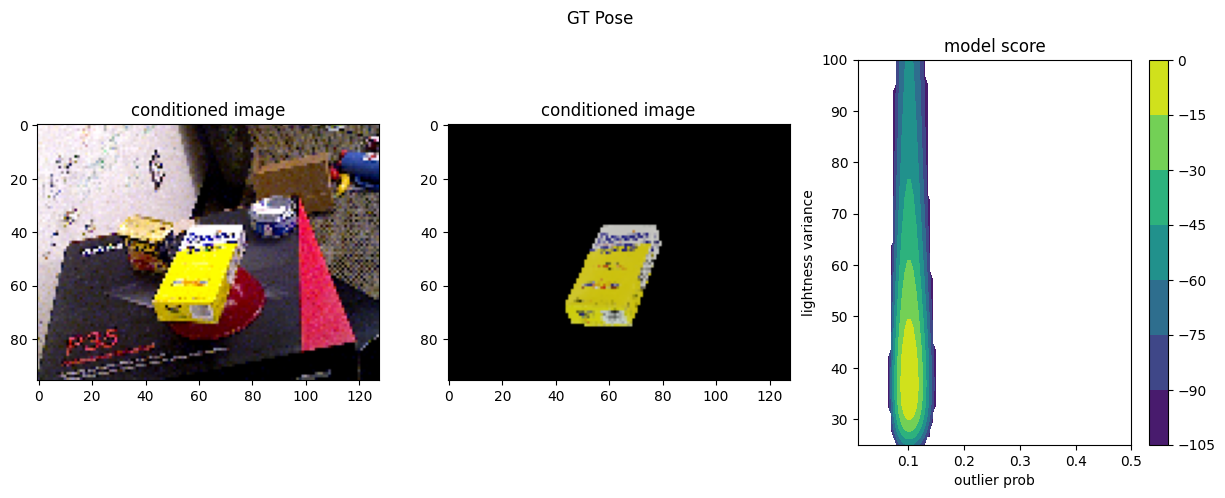

In [46]:
outlier_probability_sweep = jnp.linspace(0.01, 0.5, 100)
inlier_lightness_variance_sweep = jnp.linspace(25.0, 100.0, 50)

scores_gt = vmapped_grid_reduce(
    trace_gt,
    key,
    outlier_probability_sweep,
    inlier_lightness_variance_sweep,
    0.5,
    0.01
)

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].set_title('conditioned image')
ax[0].imshow(observed_rgbd_scaled_down[...,:3])

ax[1].imshow(rendered_rgbd_gt[...,:3])
ax[1].set_title('conditioned image')

contour_plot = ax[2].contourf(outlier_probability_sweep,inlier_lightness_variance_sweep,jnp.log(b3d.normalize_log_scores(scores_gt)))
fig.colorbar(contour_plot, ax=ax[2])
ax[2].set_xlabel('outlier prob')
ax[2].set_ylabel('lightness variance')
ax[2].set_title('model score')

plt.suptitle('GT Pose')

In [47]:
outlier_probability_sweep[jnp.argmax(scores_gt.sum(axis=0))]

Array(0.09909091, dtype=float32)

In [48]:
print('lightness var: ', inlier_lightness_variance_sweep[jnp.unravel_index(jnp.argmax(scores_gt), scores_gt.shape)[0]])
print('outlier prob var: ', outlier_probability_sweep[jnp.unravel_index(jnp.argmax(scores_gt), scores_gt.shape)[1]])

lightness var:  37.244896
outlier prob var:  0.09909091


Text(0.5, 0.98, 'Perturbed Pose')

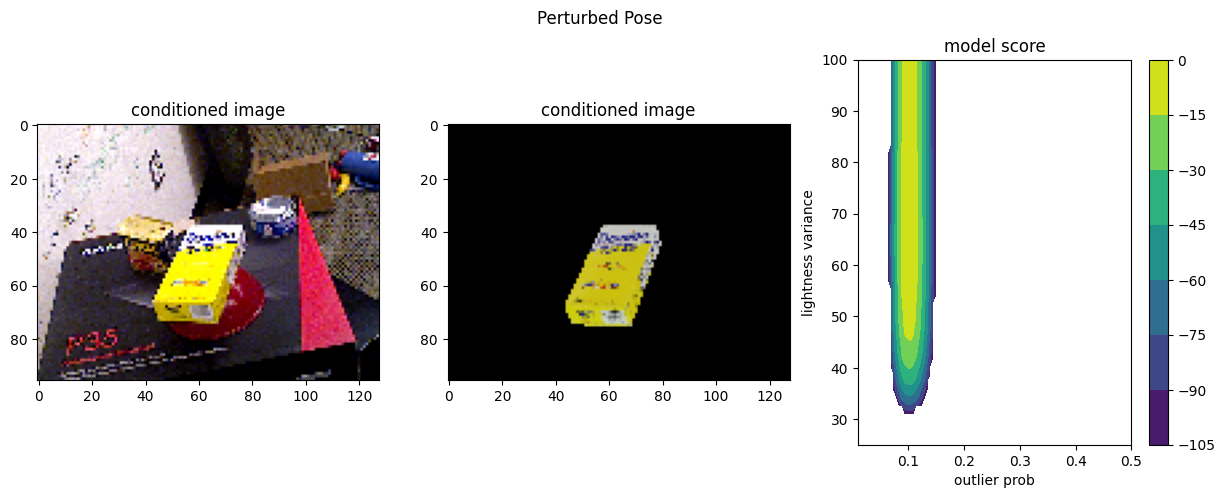

In [49]:

scores_perturbed = vmapped_grid_reduce(
    trace_perturbed,
    key,
    outlier_probability_sweep,
    inlier_lightness_variance_sweep,
    0.25,
    0.01
)

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].set_title('conditioned image')
ax[0].imshow(observed_rgbd_scaled_down[...,:3])

ax[1].imshow(rendered_rgbd_gt[...,:3])
ax[1].set_title('conditioned image')

contour_plot = ax[2].contourf(outlier_probability_sweep,inlier_lightness_variance_sweep,jnp.log(b3d.normalize_log_scores(scores_perturbed)))
fig.colorbar(contour_plot, ax=ax[2])
ax[2].set_xlabel('outlier prob')
ax[2].set_ylabel('lightness variance')
ax[2].set_title('model score')

plt.suptitle('Perturbed Pose')

In [50]:
outlier_probability_sweep[jnp.argmax(scores_perturbed.sum(axis=0))]

Array(0.09909091, dtype=float32)

In [45]:
print('lightness var: ', inlier_lightness_variance_sweep[jnp.unravel_index(jnp.argmax(scores_perturbed), scores_perturbed.shape)[0]])
print('outlier prob var: ', outlier_probability_sweep[jnp.unravel_index(jnp.argmax(scores_perturbed), scores_perturbed.shape)[1]])

lightness var:  60.20408
outlier prob var:  0.10404041


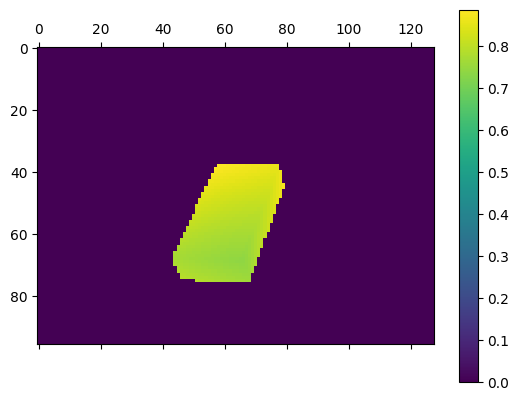

In [53]:
plt.matshow(rendered_rgbd_gt[...,3])
plt.colorbar()

In [17]:
# low res effect for aidan's notebook

In [18]:
observed_rgbd_scaled_down_dimmed = observed_rgbd_scaled_down.at[20:40,20:40,:3].set(observed_rgbd_scaled_down[20:40,20:40,:3]*0.2)

In [19]:
trace_dimmed, key = trace_from_parameters(
    jax.random.PRNGKey(10),
    rendered_rgbd_gt,
    10000,
    rendered_rgbd_gt.shape[0], rendered_rgbd_gt.shape[1],
    inlier_lightness_variance=10.0,
    inlier_color_variance=40.0,
    inlier_depth_variance=0.1,
    outlier_probability=0.1,
    observed_rgbd=observed_rgbd_scaled_down_dimmed
)

outlier_probability_sweep = jnp.linspace(0.01, 0.5, 100)
inlier_lightness_variance_sweep = jnp.linspace(50, 125.0, 50)

scores_dimmed = vmapped_grid_reduce(
    trace_dimmed,
    key,
    outlier_probability_sweep,
    inlier_lightness_variance_sweep,
    1.0,
    1.0
)

Text(0.5, 0.98, 'Dimmed Patch')

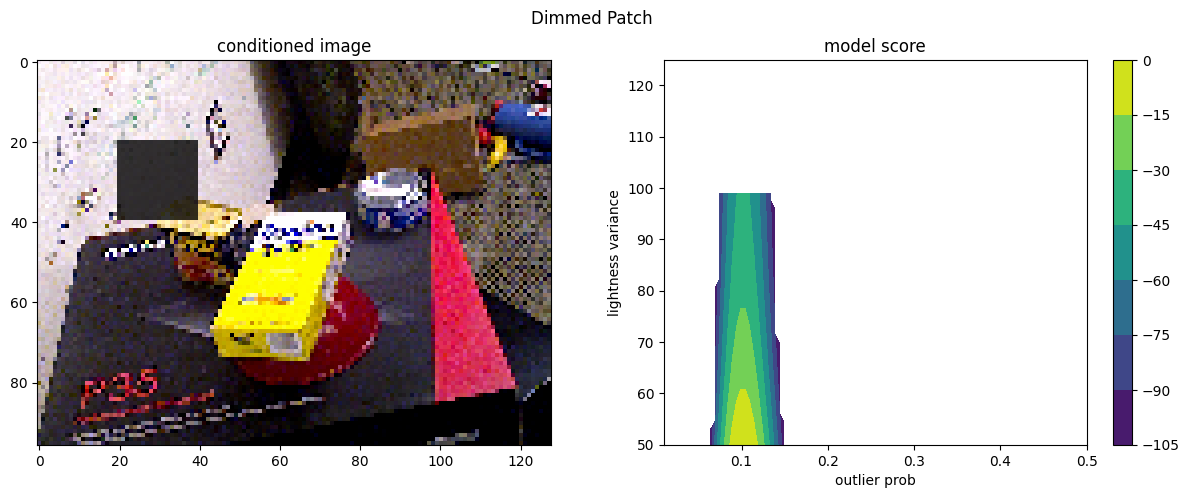

In [20]:
# plt.matshow(jnp.log(b3d.normalize_log_scores(scores)))

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].set_title('conditioned image')
ax[0].imshow(observed_rgbd_scaled_down_dimmed[...,:3])

contour_plot = ax[1].contourf(outlier_probability_sweep,inlier_lightness_variance_sweep,jnp.log(b3d.normalize_log_scores(scores_dimmed)))
fig.colorbar(contour_plot, ax=ax[1])
ax[1].set_xlabel('outlier prob')
ax[1].set_ylabel('lightness variance')
ax[1].set_title('model score')

plt.suptitle('Dimmed Patch')